<h2>Exploratory Data Analysis (EDA)</h1>

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data_wrangling.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,CustomerID,Country,ItemTotal
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


C:\Users\Billy\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Billy\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Billy\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


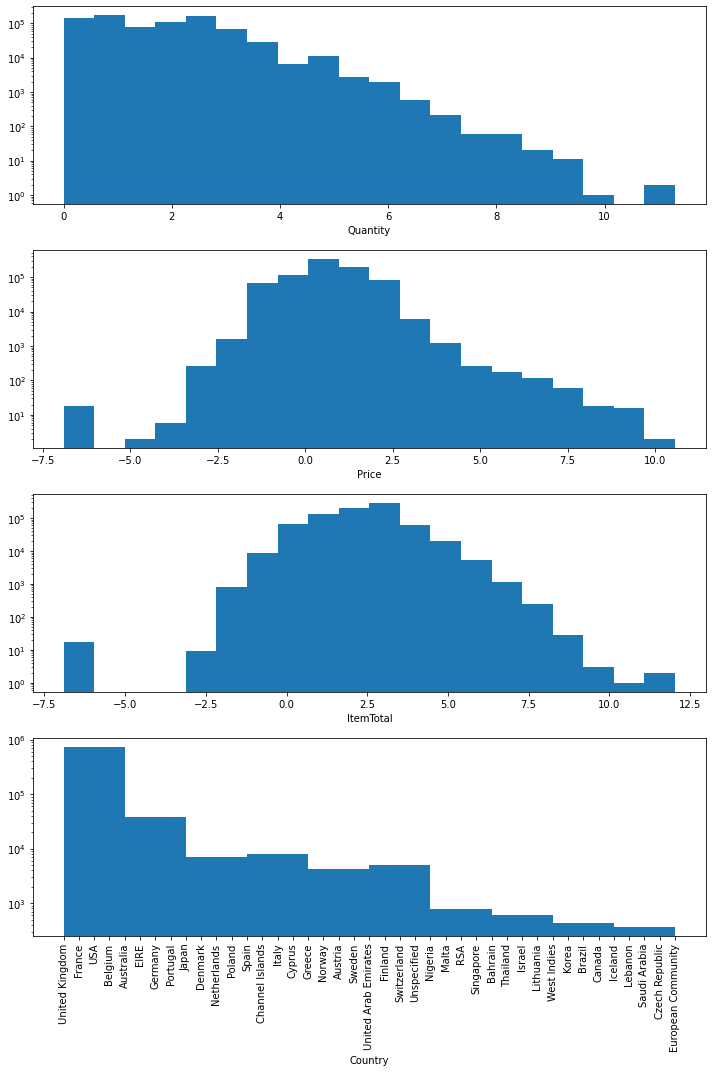

In [60]:
#create histograms for features
plt.figure(figsize=(10,15))

plt.subplot(4,1,1)
plt.hist(np.log(df.Quantity),bins=20)
plt.yscale('log')
plt.xlabel('Quantity')

plt.subplot(4,1,2)
plt.hist(np.log(df.Price),bins=20)
plt.yscale('log')
plt.xlabel('Price')

plt.subplot(4,1,3)
plt.hist(np.log(df.ItemTotal),bins=20)
plt.yscale('log')
plt.xlabel('ItemTotal')

plt.subplot(4,1,4)
plt.hist(df.Country)
plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Country')

plt.tight_layout()

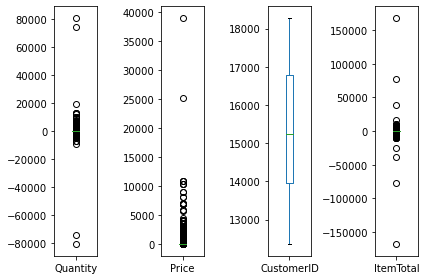

In [59]:
#create box plots
df.plot(kind='box', subplots=True)
plt.tight_layout()

Text(0.5, 1.0, 'Feature Correlation Heatmap')

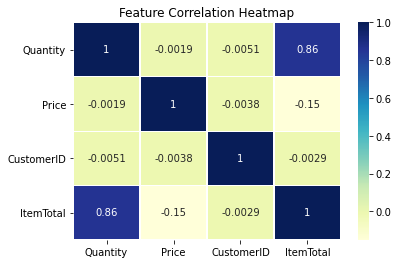

In [49]:
#create a feature correlation matrix heatmap
correlation = df.corr()
sns.heatmap(correlation, annot=True, linewidth=0.1, cmap='YlGnBu')
plt.title('Feature Correlation Heatmap')

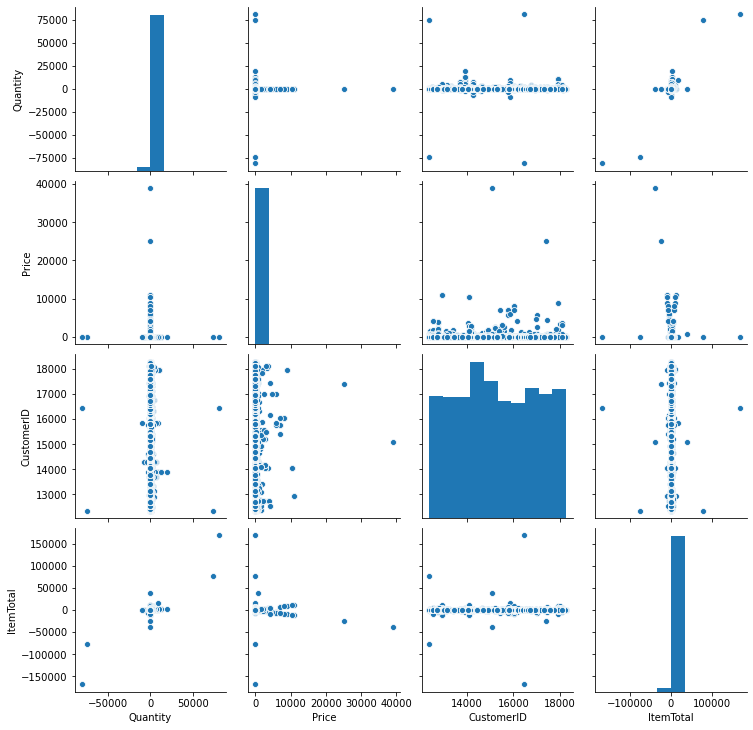

In [50]:
#create a pairplot
sns.pairplot(df)

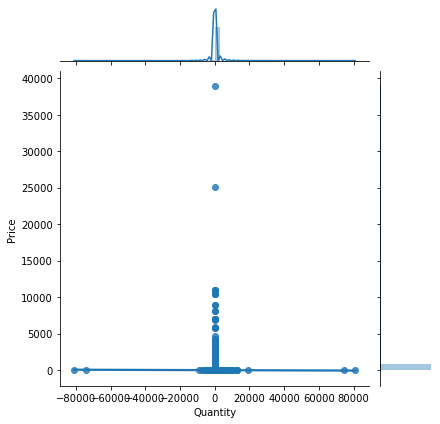

In [64]:
#create a jointplot
sns.jointplot(x='Quantity', y='Price', data=df, kind='reg')